# Z2 lattice gauge theory

In [1]:
# The C2QA package is currently not published to PyPI.
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Cheat to get MS Visual Studio Code Jupyter server to recognize Python venv
module_path = os.path.abspath(os.path.join("../../venv/Lib/site-packages"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import c2qa
import qiskit
import numpy as np
import scipy
import itertools
import c2qa.util as util
import c2qa.stateReadout as stateReadout
import matplotlib.pyplot as plt
import matplotlib
# Import Qiskit
from qiskit import QuantumCircuit
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
import qiskit.quantum_info as qi
from qiskit.providers.aer import AerSimulator
from qiskit import IBMQ
from collections import Counter

# Controlled phase beamsplitter oscillation

### Create a circuit with as many modes as qubits

In [3]:
numberofmodes=2
numberofqubitspermode=1
cutoff=2**numberofqubitspermode

qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = qiskit.QuantumRegister(size=1)
cbr = qiskit.ClassicalRegister(size=1)
circuit = c2qa.CVCircuit(qmr, qbr, cbr)
# circuit = c2qa.CVCircuit(qmr)

### Initialise, e.g. share one boson between two cavities by initialising one cavity to Fock state 1 and the other to the vacuum.

In [4]:
diffstallmodes=[1,0]
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(diffstallmodes[i], qmr[i])

In [5]:
def eiht(circuit, qma, qmb, qb, m, g, dt):
    circuit.cv_cpbs(np.pi*dt, qmb, qma, qb)
    # circuit.cv_r(dt*m, qma)
    # circuit.cv_r(dt*m, qmb)
    # circuit.rx(-2*g*dt, qb)
    return circuit

In [6]:
dt=1
m=1
g=1
N=5

circuit.h(qbr[0]) # Inititialises the qubit to a plus state (so that pauli Z flips it)
stateop, _ = c2qa.util.simulate(circuit)
util.stateread(stateop, qbr.size, numberofmodes, cutoff)
for i in range(N):
    print("dt+1")
    eiht(circuit, qmr[0], qmr[1], qbr[0], m, g, dt)
    stateop, _ = c2qa.util.simulate(circuit)
    util.stateread(stateop, qbr.size, numberofmodes, cutoff)

qumodes:  01  qubits:  0     with amplitude:  0.7071067811865476
qumodes:  01  qubits:  1     with amplitude:  0.7071067811865475
occupation hello  [0.0, 1.0]
dt+1
qumodes:  10  qubits:  0     with amplitude:  -0.7071067811865476
qumodes:  10  qubits:  1     with amplitude:  0.7071067811865475
occupation hello  [1.0, 0.0]
dt+1
qumodes:  01  qubits:  0     with amplitude:  -0.7071067811865476
qumodes:  01  qubits:  1     with amplitude:  -0.7071067811865475
occupation hello  [0.0, 1.0]
dt+1
qumodes:  10  qubits:  0     with amplitude:  0.7071067811865476
qumodes:  10  qubits:  1     with amplitude:  -0.7071067811865475
occupation hello  [1.0, 0.0]
dt+1
qumodes:  01  qubits:  0     with amplitude:  0.7071067811865476
qumodes:  01  qubits:  1     with amplitude:  0.7071067811865475
occupation hello  [0.0, 1.0]
dt+1
qumodes:  10  qubits:  0     with amplitude:  -0.7071067811865476
qumodes:  10  qubits:  1     with amplitude:  0.7071067811865475
occupation hello  [1.0, 0.0]


/home/richard/anaconda3/envs/c2qa/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/richard/anaconda3/envs/c2qa/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [7]:
circuit.measure(qbr[0],cbr[0])
stateop, result = c2qa.util.simulate(circuit)
util.stateread(stateop, qbr.size, numberofmodes, 4)
print('Counts(ideal):', result.get_counts())

qumodes:  20  qubits:  1     with amplitude:  1.0
occupation hello  [2.0, 0.0]
Counts(ideal): {'0': 491, '1': 533}


# Mode occupation for Z2LGT (Aidelsburger Nature)

### Create a circuit with as many modes as qubits

In [3]:
numberofqubits=4
numberofmodes=5
numberofqubitspermode=2
cutoff=2**numberofqubitspermode

qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = qiskit.QuantumRegister(size=numberofqubits)
cbr = qiskit.ClassicalRegister(size=1)
circuit = c2qa.CVCircuit(qmr, qbr, cbr)
# circuit = c2qa.CVCircuit(qmr)

### Initialise, e.g. share one boson between two cavities by initialising one cavity to Fock state 1 and the other to the vacuum.

In [4]:
diffstallmodes=[0,0,1,0,0]
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(diffstallmodes[i], qmr[i])

stateop, _ = c2qa.util.simulate(circuit)
occ=util.stateread(stateop, qbr.size, numberofmodes, cutoff)

occupation qb  [0.0, 0.0, 0.0, 0.0]


In [5]:
def eiht(circuit, qma, qmb, qb, m, g, dt):
    circuit.cv_cpbs(np.pi*dt, qmb, qma, qb)
    # circuit.cv_r(dt*m, qma)
    # circuit.cv_r(dt*m, qmb)
    circuit.rx(-g*dt, qb)
    return circuit

In [22]:
dt=0.1
m=1
# g=0.1
g=2
N=10
occs=np.zeros((N,numberofmodes))

for i in range(numberofqubits):
    circuit.h(qbr[i]) # Inititialises the qubit to a plus state (so that pauli Z flips it)
print("initial state ")
stateop, _ = c2qa.util.simulate(circuit)
util.stateread(stateop, qbr.size, numberofmodes, cutoff)
for i in range(N):
    print("dt+1", i*dt)
    for j in range(0,numberofmodes-1,2):
        eiht(circuit, qmr[j+1], qmr[j], qbr[j], m, g, dt)
    for j in range(1,numberofmodes-1,2):
        eiht(circuit, qmr[j+1], qmr[j], qbr[j], m, g, dt)
    stateop, result = c2qa.util.simulate(circuit)
    omething=util.stateread(stateop, qbr.size, numberofmodes, 4)
    print("occ main ", list(omething))
    occs[i]=np.array(list(omething))

initial state 
qumodes:  00100  qubits:  0000     with amplitude:  0.25000000000000006
qumodes:  00100  qubits:  0001     with amplitude:  0.25000000000000006
qumodes:  00100  qubits:  0010     with amplitude:  0.25000000000000006
qumodes:  00100  qubits:  0011     with amplitude:  0.25
qumodes:  00100  qubits:  0100     with amplitude:  0.25000000000000006
qumodes:  00100  qubits:  0101     with amplitude:  0.25
qumodes:  00100  qubits:  0110     with amplitude:  0.25
qumodes:  00100  qubits:  0111     with amplitude:  0.24999999999999994
qumodes:  00100  qubits:  1000     with amplitude:  0.25000000000000006
qumodes:  00100  qubits:  1001     with amplitude:  0.25
qumodes:  00100  qubits:  1010     with amplitude:  0.25
qumodes:  00100  qubits:  1011     with amplitude:  0.24999999999999994
qumodes:  00100  qubits:  1100     with amplitude:  0.25
qumodes:  00100  qubits:  1101     with amplitude:  0.24999999999999994
qumodes:  00100  qubits:  1110     with amplitude:  0.2499999999999

/home/richard/anaconda3/envs/c2qa/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/richard/anaconda3/envs/c2qa/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


qumodes:  00010  qubits:  0000     with amplitude:  -0.03785715352148013
qumodes:  00100  qubits:  0000     with amplitude:  0.22463025678182766
qumodes:  01000  qubits:  0000     with amplitude:  0.03785715352148013
qumodes:  10000  qubits:  0000     with amplitude:  0.006117935463105805
qumodes:  00010  qubits:  0001     with amplitude:  -0.03785715352148013
qumodes:  00100  qubits:  0001     with amplitude:  0.22463025678182763
qumodes:  01000  qubits:  0001     with amplitude:  0.037857153521480134
qumodes:  10000  qubits:  0001     with amplitude:  0.006117935463105804
qumodes:  00010  qubits:  0010     with amplitude:  0.037857153521480134
qumodes:  00100  qubits:  0010     with amplitude:  0.22463025678182758
qumodes:  01000  qubits:  0010     with amplitude:  0.03785715352148013
qumodes:  10000  qubits:  0010     with amplitude:  0.006117935463105804
qumodes:  00010  qubits:  0011     with amplitude:  0.03785715352148012
qumodes:  00100  qubits:  0011     with amplitude:  0.224

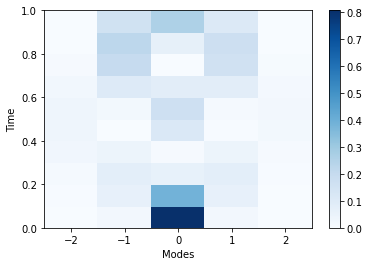

In [23]:
plt.pcolormesh(np.arange(numberofmodes+1)-numberofmodes//2-0.5,np.arange(N+1)*dt,occs,cmap=matplotlib.cm.Blues,linewidth=0,rasterized=True)
plt.xlabel("Modes")
plt.ylabel("Time")
plt.colorbar()

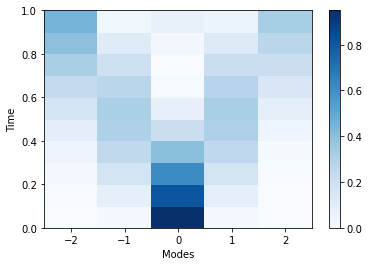

In [17]:
plt.pcolormesh(np.arange(numberofmodes+1)-numberofmodes//2-0.5,np.arange(N+1)*dt,occs,cmap=matplotlib.cm.Blues,linewidth=0,rasterized=True)
plt.xlabel("Modes")
plt.ylabel("Time")
plt.colorbar()

In [ ]:
circuit.draw(output='mpl', filename='lgt_circuit.png')

In [ ]:
circuit.measure(qbr[0],cbr[0])
stateop, result = c2qa.util.simulate(circuit)
util.stateread(stateop, qbr.size, numberofmodes, 4)
print('Counts(ideal):', result.get_counts())

# Qubit state for Z2LGT

### Create a circuit with as many modes as qubits

In [6]:
numberofqubits=4
numberofmodes=5
numberofqubitspermode=2
cutoff=2**numberofqubitspermode

qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = qiskit.QuantumRegister(size=numberofqubits)
cbr = qiskit.ClassicalRegister(size=1)
circuit = c2qa.CVCircuit(qmr, qbr, cbr)
# circuit = c2qa.CVCircuit(qmr)

### Initialise, e.g. share one boson between two cavities by initialising one cavity to Fock state 1 and the other to the vacuum.

In [7]:
diffstallmodes=[0,0,1,0,0]
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(diffstallmodes[i], qmr[i])

stateop, _ = c2qa.util.simulate(circuit)
occ=util.stateread(stateop, qbr.size, numberofmodes, cutoff)

occupation qb  [0.0, 0.0, 0.0, 0.0]


In [8]:
def eiht(circuit, qma, qmb, qb, m, g, dt):
    circuit.cv_cpbs(np.pi*dt, qmb, qma, qb)
    # circuit.cv_r(dt*m, qma)
    # circuit.cv_r(dt*m, qmb)
    circuit.rx(-g*dt, qb)
    return circuit

In [9]:
dt=0.1
m=1
g=0.1 # Controlled phase beamsplitter dominates
# g=2 #
N=40
occs=np.zeros((N,numberofqubits))

for i in range(numberofqubits):
    circuit.h(qbr[i]) # Inititialises the qubit to a plus state (so that pauli Z flips it)
print("initial state ")
stateop, _ = c2qa.util.simulate(circuit)
util.stateread(stateop, qbr.size, numberofmodes, cutoff)
for i in range(N):
    print("dt+1", i*dt)
    for j in range(0,numberofmodes-1,2):
        eiht(circuit, qmr[j+1], qmr[j], qbr[j], m, g, dt)
    for j in range(1,numberofmodes-1,2):
        eiht(circuit, qmr[j+1], qmr[j], qbr[j], m, g, dt)
    stateop, result = c2qa.util.simulate(circuit)
    omething=util.stateread(stateop, qbr.size, numberofmodes, 4)
    print("occ main ", list(omething))
    occs[i]=np.array(list(omething))

initial state 
occupation qb  [0.49999999999999994, 0.49999999999999994, 0.49999999999999994, 0.49999999999999994]
dt+1 0.0


/home/richard/anaconda3/envs/c2qa/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/richard/anaconda3/envs/c2qa/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


occupation qb  [0.4998073070916392, 0.4998073070916392, 0.4998073070916392, 0.4998073070916392]
occ main  [0.4998073070916392, 0.4998073070916392, 0.4998073070916392, 0.4998073070916392]
dt+1 0.1
occupation qb  [0.49927313012057223, 0.49927313012057223, 0.49927313012057223, 0.49927313012057223]
occ main  [0.49927313012057223, 0.49927313012057223, 0.49927313012057223, 0.49927313012057223]
dt+1 0.2
occupation qb  [0.49849631218737456, 0.49849631218737445, 0.4984963121873745, 0.4984963121873745]
occ main  [0.49849631218737456, 0.49849631218737445, 0.4984963121873745, 0.4984963121873745]
dt+1 0.30000000000000004
occupation qb  [0.4975987390447631, 0.4975987390447629, 0.497598739044763, 0.497598739044763]
occ main  [0.4975987390447631, 0.4975987390447629, 0.497598739044763, 0.497598739044763]
dt+1 0.4
occupation qb  [0.4966969813485723, 0.49669698134857226, 0.4966969813485722, 0.4966969813485723]
occ main  [0.4966969813485723, 0.49669698134857226, 0.4966969813485722, 0.4966969813485723]
dt+

### Controlled phase beamsplitter larger than rotation

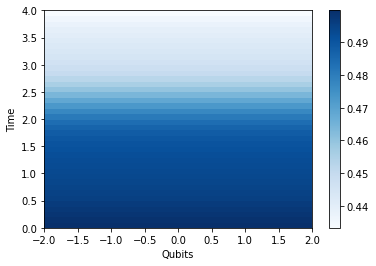

In [12]:
plt.pcolormesh(np.arange(numberofqubits+1)-numberofqubits//2,np.arange(N+1)*dt,occs,cmap=matplotlib.cm.Blues,linewidth=0,rasterized=True)
plt.xlabel("Qubits")
plt.ylabel("Time")
plt.colorbar()

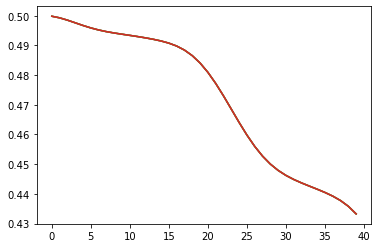

In [13]:
plt.plot(occs)

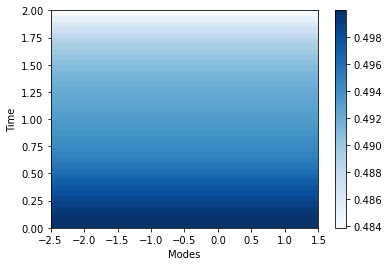

In [22]:
plt.pcolormesh(np.arange(numberofqubits+1)-numberofqubits//2-0.5,np.arange(N+1)*dt,occs,cmap=matplotlib.cm.Blues,linewidth=0,rasterized=True)
plt.xlabel("Qubits")
plt.ylabel("Time")
plt.colorbar()

In [34]:
numberofqubits=4
numberofmodes=5
numberofqubitspermode=2
cutoff=2**numberofqubitspermode

qmr = c2qa.QumodeRegister(num_qumodes=numberofmodes, num_qubits_per_qumode=numberofqubitspermode)
qbr = qiskit.QuantumRegister(size=numberofqubits)
cbr = qiskit.ClassicalRegister(size=1)
circuit = c2qa.CVCircuit(qmr, qbr, cbr)
# circuit = c2qa.CVCircuit(qmr)

### Initialise, e.g. share one boson between two cavities by initialising one cavity to Fock state 1 and the other to the vacuum.

In [35]:
diffstallmodes=[0,0,1,0,0]
for i in range(qmr.num_qumodes):
    circuit.cv_initialize(diffstallmodes[i], qmr[i])

stateop, _ = c2qa.util.simulate(circuit)
occ=util.stateread(stateop, qbr.size, numberofmodes, cutoff)

qumodes:  00100  qubits:  0000     with amplitude:  1.0
occupation qb  [0.0, 0.0, 0.0, 0.0]


In [36]:
def eiht(circuit, qma, qmb, qb, m, g, dt):
    circuit.cv_cpbs(np.pi*dt, qmb, qma, qb)
    # circuit.cv_r(dt*m, qma)
    # circuit.cv_r(dt*m, qmb)
    circuit.rx(-g*dt, qb)
    return circuit

In [37]:
dt=0.01
m=1
# g=0.1
g=2
N=40
occs=np.zeros((N,numberofqubits))

for i in range(numberofqubits):
    circuit.h(qbr[i]) # Inititialises the qubit to a plus state (so that pauli Z flips it)
print("initial state ")
stateop, _ = c2qa.util.simulate(circuit)
util.stateread(stateop, qbr.size, numberofmodes, cutoff)
for i in range(N):
    print("dt+1", i*dt)
    for j in range(0,numberofmodes-1,2):
        eiht(circuit, qmr[j+1], qmr[j], qbr[j], m, g, dt)
    for j in range(1,numberofmodes-1,2):
        eiht(circuit, qmr[j+1], qmr[j], qbr[j], m, g, dt)
    stateop, result = c2qa.util.simulate(circuit)
    omething=util.stateread(stateop, qbr.size, numberofmodes, 4)
    print("occ main ", list(omething))
    occs[i]=np.array(list(omething))

initial state 
qumodes:  00100  qubits:  0000     with amplitude:  0.25000000000000006
qumodes:  00100  qubits:  0001     with amplitude:  0.25000000000000006
qumodes:  00100  qubits:  0010     with amplitude:  0.25000000000000006
qumodes:  00100  qubits:  0011     with amplitude:  0.25
qumodes:  00100  qubits:  0100     with amplitude:  0.25000000000000006
qumodes:  00100  qubits:  0101     with amplitude:  0.25
qumodes:  00100  qubits:  0110     with amplitude:  0.25
qumodes:  00100  qubits:  0111     with amplitude:  0.24999999999999994
qumodes:  00100  qubits:  1000     with amplitude:  0.25000000000000006
qumodes:  00100  qubits:  1001     with amplitude:  0.25
qumodes:  00100  qubits:  1010     with amplitude:  0.25
qumodes:  00100  qubits:  1011     with amplitude:  0.24999999999999994
qumodes:  00100  qubits:  1100     with amplitude:  0.25
qumodes:  00100  qubits:  1101     with amplitude:  0.24999999999999994
qumodes:  00100  qubits:  1110     with amplitude:  0.2499999999999

###  Rotation larger than controlled phase beamsplitter

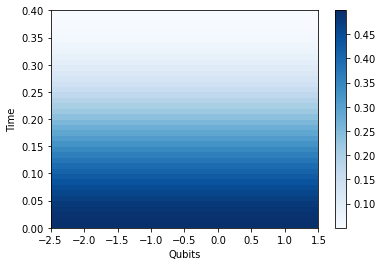

In [39]:
plt.pcolormesh(np.arange(numberofqubits+1)-numberofqubits//2-0.5,np.arange(N+1)*dt,occs,cmap=matplotlib.cm.Blues,linewidth=0,rasterized=True)
plt.xlabel("Qubits")
plt.ylabel("Time")
plt.colorbar()